In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix ,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight 
from classification_utilities import display_cm, display_adj_cm
from ReadData import *
from Accuracy import accuracy, accuracy_adjacent

In [2]:
%cd ./logs
from log_well import *
%cd ../

d:\texas_data_set\Regularize\logs
d:\texas_data_set\Regularize


In [3]:
well_number1, well_number2, well_number3, well_number4, well_number5, well_number6, well_number7, well_number8, well_number9, well_number10, well_number11, well_number12, WellName = ReadData()

In [4]:
training_data = pd.concat([well_number1, well_number2, well_number4, well_number5, well_number6, well_number7, well_number8, well_number9])
test_data = well_number3

training_data = training_data.drop('Well Name', axis=1)
test_data = test_data.drop('Well Name', axis=1)

X_training = training_data.drop('Facies', axis=1)
Y_training = training_data['Facies']

X_test = test_data.drop('Facies', axis=1)
Y_test = test_data['Facies']

Robust = RobustScaler().fit(X_training)
X_training = Robust.transform(X_training)
X_test = Robust.transform(X_test)

Standard = StandardScaler().fit(X_training)
X_training = Standard.transform(X_training)
X_test = Standard.transform(X_test)

MinMax = MinMaxScaler().fit(X_training)
X_training = MinMax.transform(X_training)
X_test = MinMax.transform(X_test)

a =  np.unique(Y_training)
weights = compute_class_weight(class_weight='balanced', classes=a, y=Y_training)
weights = dict(zip(np.unique(Y_training), weights))

In [17]:
XGboost = GradientBoostingClassifier(random_state=42)

param_grid = { 
    # 'sample_weight' : weights,
    # 'tree_method':'gpu_hist',
    # 'n_gpus': 1, 
    'n_estimators': np.linspace(1,21,10).astype(int),
    'learning_rate': np.linspace(0,1,10),
    'min_samples_leaf' : np.linspace(1,51,5).astype(int),
    'min_weight_fraction_leaf' : np.linspace(0,0.5,6),
    'max_depth' : np.linspace(1,51,5).astype(int)   
    
}

CV_XGboost = GridSearchCV(estimator=XGboost, param_grid=param_grid, cv= 5)
CV_XGboost.fit(X_training, Y_training)

c:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
7500 fits failed out of a total of 75000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Program Files\Python310\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "c:\Program Files\Python310\lib\site-packages\sklearn\ensemble\_gb.py", line 274, in _check_params
    raise ValueError(
ValueError: learning_rate must be greater than 0 b

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                         'max_depth': array([ 1, 13, 26, 38, 51]),
                         'min_samples_leaf': array([ 1, 13, 26, 38, 51]),
                         'min_weight_fraction_leaf': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
                         'n_estimators': array([ 1,  3,  5,  7,  9, 12, 14, 16, 18, 21])})

In [18]:
CV_XGboost.best_params_

{'learning_rate': 0.2222222222222222,
 'max_depth': 1,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 21}

In [20]:
XGboost = GradientBoostingClassifier(learning_rate=0.2222222222222222, max_depth=1, min_samples_leaf=1, min_weight_fraction_leaf=0.1,n_estimators=21,random_state=42).fit(X_training, Y_training)

Y_Pred  = XGboost.predict(X_test)
well_number3['Prediction'] = Y_Pred
conf = confusion_matrix(Y_test, Y_Pred)
display_cm(conf, Y_test)

           Pred      SS      CSiS      FSiS      SiSh      MS      WS      D      PS      BS Total
           True
             SS     0.0      86.0       3.0       0.0     0.0     0.0    0.0     0.0     0.0  89.0
           CSiS     0.0      68.0      21.0       0.0     0.0     0.0    0.0     0.0     0.0  89.0
           FSiS     0.0      39.0      78.0       0.0     0.0     0.0    0.0     0.0     0.0 117.0
           SiSh     0.0       0.0       0.0       1.0     4.0     1.0    0.0     1.0     0.0   7.0
             MS     0.0       0.0       0.0       9.0     7.0     2.0    0.0     1.0     0.0  19.0
             WS     0.0       1.0       0.0       8.0    22.0    28.0    0.0    12.0     0.0  71.0
              D     0.0       0.0       0.0       0.0     0.0     0.0    1.0    16.0     0.0  17.0
             PS     0.0       0.0       0.0       0.0     1.0     9.0    0.0    30.0     0.0  40.0
             BS     0.0       0.0       0.0       0.0     0.0     0.0    0.0     0.0     0.0 

d:\texas_data_set\Regularize\classification_utilities.py:15: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(conf)/conf.sum(axis=0).astype('float')
d:\texas_data_set\Regularize\classification_utilities.py:16: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(conf)/conf.sum(axis=1).astype('float')


In [21]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
display_adj_cm(conf, Y_test, adjacent_facies)

           Pred      SS      CSiS      FSiS      SiSh      MS      WS      D      PS      BS Total
           True
             SS    86.0       0.0       3.0       0.0     0.0     0.0    0.0     0.0     0.0  89.0
           CSiS     0.0      89.0       0.0       0.0     0.0     0.0    0.0     0.0     0.0  89.0
           FSiS     0.0       0.0     117.0       0.0     0.0     0.0    0.0     0.0     0.0 117.0
           SiSh     0.0       0.0       0.0       5.0     0.0     1.0    0.0     1.0     0.0   7.0
             MS     0.0       0.0       0.0       0.0    18.0     0.0    0.0     1.0     0.0  19.0
             WS     0.0       1.0       0.0       8.0     0.0    62.0    0.0     0.0     0.0  71.0
              D     0.0       0.0       0.0       0.0     0.0     0.0   17.0     0.0     0.0  17.0
             PS     0.0       0.0       0.0       0.0     1.0     0.0    0.0    39.0     0.0  40.0
             BS     0.0       0.0       0.0       0.0     0.0     0.0    0.0     0.0     0.0 

C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_7216\982180069.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
d:\texas_data_set\Regularize\classification_utilities.py:118: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(conf)/conf.sum(axis=0).astype('float')
d:\texas_data_set\Regularize\classification_utilities.py:119: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(conf)/conf.sum(axis=1).astype('float')


In [22]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6]])
conf = confusion_matrix(Y_test, Y_Pred)
print('Optimized facies classification accuracy = %.2f' % accuracy(conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(conf, adjacent_facies))

Optimized facies classification accuracy = 0.47
Optimized adjacent facies classification accuracy = 0.96


C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_7216\25726603.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6]])


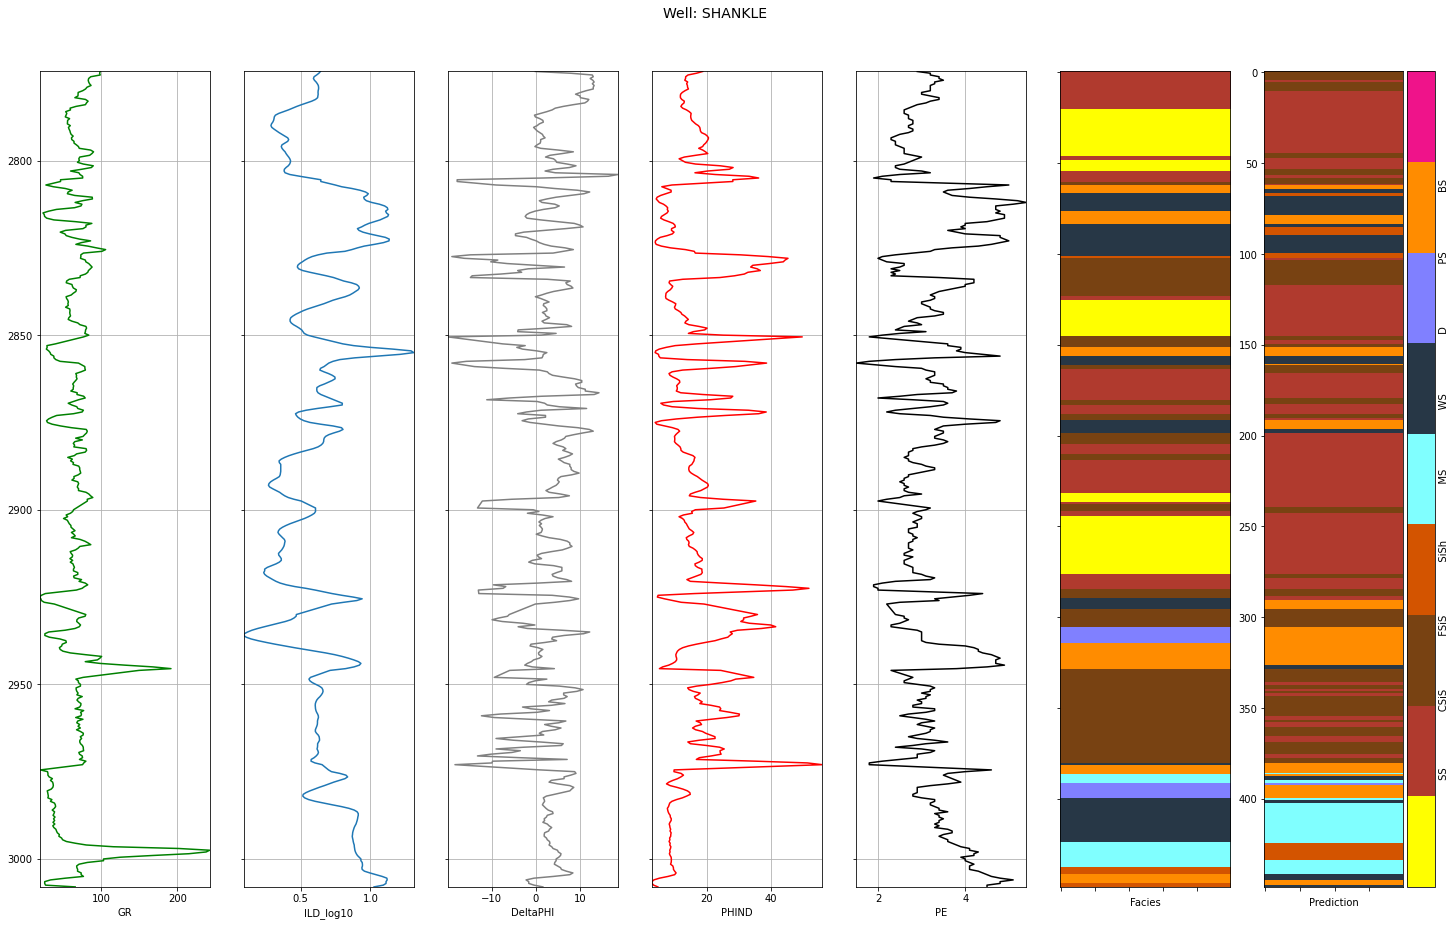

In [23]:
compare_facies_plot(well_number3, 'Prediction', test_data['Depth'].min(), test_data['Depth'].max())

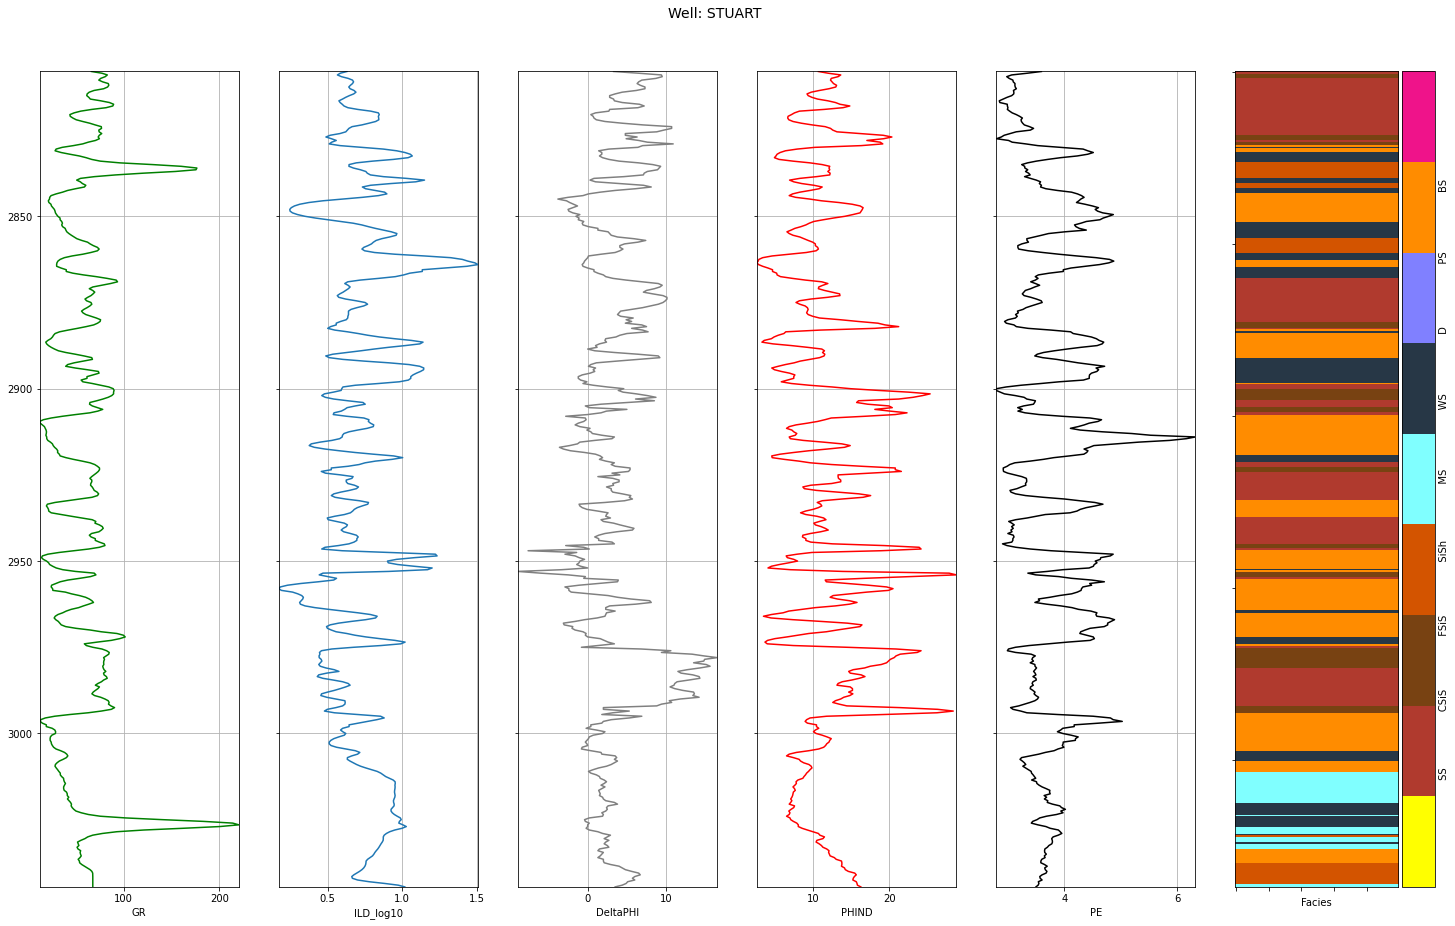

In [24]:
X_well11 = Robust.transform(well_number11.drop(['Well Name', 'Facies'], axis=1))
X_well11 = Standard.transform(X_well11)
X_well11 = MinMax.transform(X_well11)

Y_Pred  = XGboost.predict(X_well11)
well_number11['Facies'] = Y_Pred
log_well(well_number11.sort_values("Depth"), well_number11['Depth'].min(), well_number11['Depth'].max())

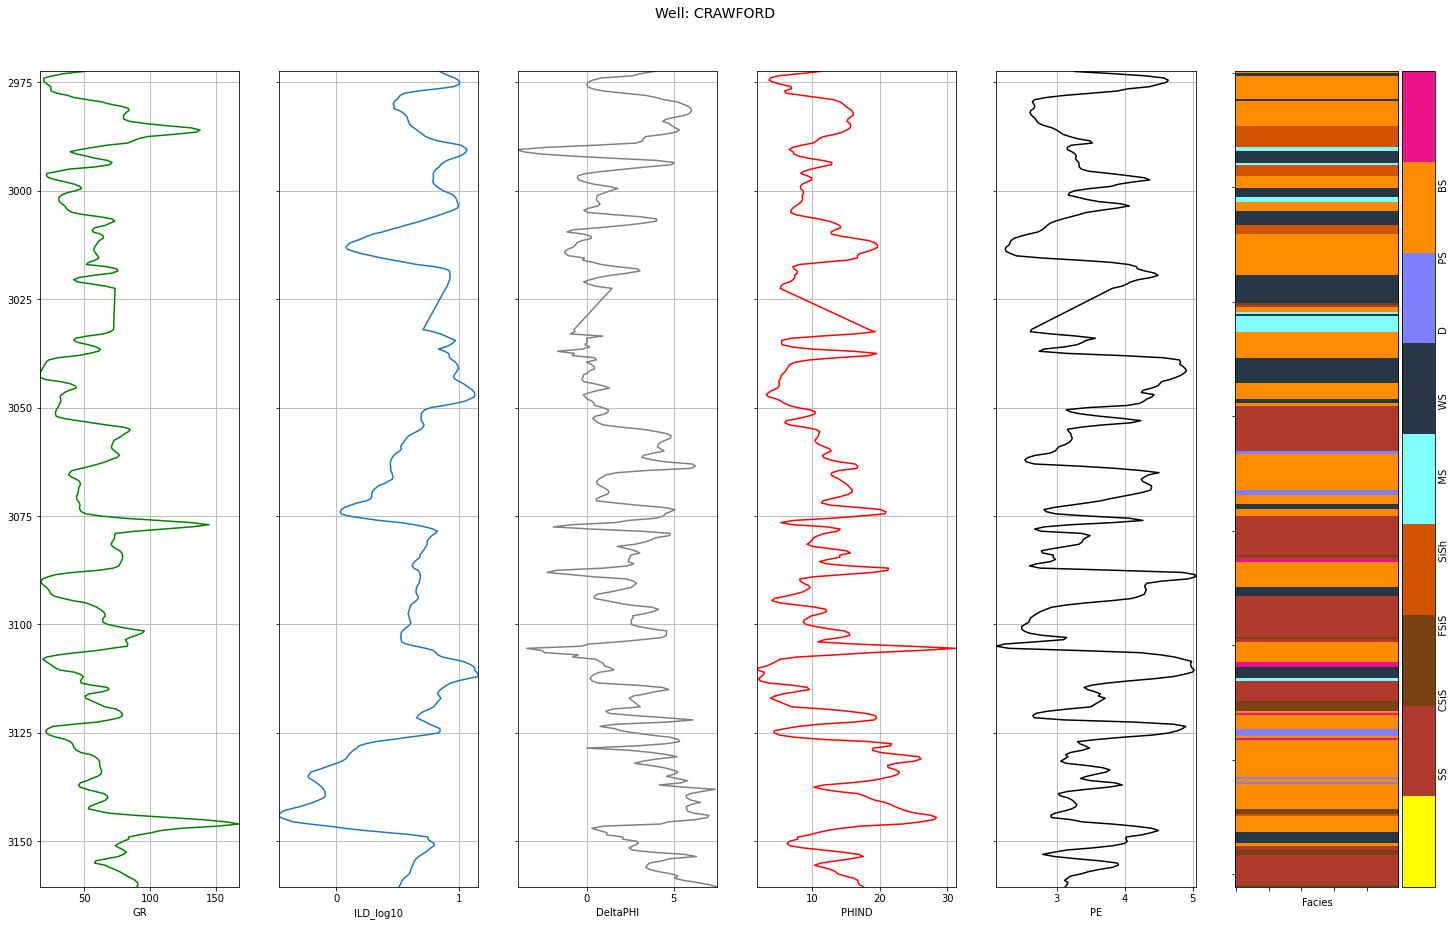

In [25]:
X_well12 = Robust.transform(well_number12.drop(['Well Name', 'Facies'], axis=1))
X_well12 = Standard.transform(X_well12)
X_well12 = MinMax.transform(X_well12)

Y_Pred  = XGboost.predict(X_well12)
well_number12['Facies'] = Y_Pred
log_well(well_number12.sort_values("Depth"), well_number12['Depth'].min(), well_number12['Depth'].max())